In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
train = pd.read_csv('../data/raw/train.csv')

In [3]:
test = pd.read_csv('../data/raw/test.csv')

In [4]:
train["dt"] = pd.to_datetime(train.timestamp)

In [7]:
from sklearn.linear_model import SGDRegressor

In [8]:
def reload_data():
    global train
    train = pd.read_csv('../data/raw/train.csv')
    global test
    test = pd.read_csv('../data/raw/test.csv')
    
def prepare_data(x1, x2=None):
    global train
    train = x1(train)
    if x2 != None:
        global test
        test = x2(test)

In [9]:
prepare_data(lambda df: df[df['full_sq'] > 8])
prepare_data(lambda df: df[df['price_doc'] > 2000000])

In [10]:
test.full_sq = np.where((test.full_sq < test.life_sq) & ((test.full_sq < 8) | (3 > (test.life_sq / test.full_sq))), test.life_sq, test.full_sq)

In [11]:
train['price_per_m2'] = train['price_doc'] / train['full_sq']

In [12]:

def comp_mse(df, features):
    kf = KFold(n_splits=5, shuffle=True) #random_state=42)
    target = "price_per_m2"

    msle_list = []
    mse_list = []
    for i, (train_index, val_index) in enumerate(kf.split(df)):    
        train_part = df.iloc[train_index, : ]
        val_part = df.iloc[val_index, :]
        model = SGDRegressor()
        model.fit(X=train_part[features].fillna(0), y = train_part[target])

        val_predication = model.predict(val_part[features].fillna(0)).clip(0, 100000000000)

        mse = mean_squared_error(val_predication, val_part[target])
        msle = mean_squared_log_error(val_predication, val_part[target])

        pirce_mse = mean_squared_error(val_predication * val_part['full_sq'], val_part['price_doc'])
        pirce_msle = mean_squared_log_error(val_predication * val_part['full_sq'], val_part['price_doc'])

        print(f'Fold full {i}: msle {pirce_msle}, mse {pirce_mse}')
        msle_list.append(pirce_msle)
        mse_list.append(pirce_mse)
        
    print(f'MSLE average = {np.mean(msle_list)}, std = {np.std(msle_list)}')

In [13]:
def predict_n_write_csv(features, path="predict1.csv"):
    target = "price_per_m2"
    
    model = SGDRegressor()
    model.fit(X=train[features].fillna(0.0), y = train[target])
    
    test[target] = model.predict(test[features].fillna(0))
    sample_submission = pd.read_csv("../data/raw/sample_submission.csv")
    sample_submission['price_doc'] = (test[target] * test['full_sq']).clip(0, 100000000000)
    sample_submission.to_csv(path, index= False)

In [14]:
features = ["metro_km_walk"]
comp_mse(train, features)
predict_n_write_csv(features, "metro_km.csv")

Fold full 0: msle 1.3637211340781583, mse 112990944882230.06
Fold full 1: msle 1.4870872142583471, mse 12227482469764.57
Fold full 2: msle 0.12926175534008472, mse 14537524871996.666
Fold full 3: msle 0.2251036948731338, mse 11265201659956.46
Fold full 4: msle 0.4347932597188855, mse 15362006618809.928
MSLE average = 0.7279934116537219, std = 0.5792611036177129


# Score 1.78762

In [15]:
features = ["kremlin_km"]
comp_mse(train, features)
predict_n_write_csv(features, "kremlin_km.csv")

Fold full 0: msle 0.27894787993480724, mse 9221292446956.855
Fold full 1: msle 0.44824490756617097, mse 14388472864152.67
Fold full 2: msle 0.11953509955735678, mse 10618259156312.473
Fold full 3: msle 0.45396489905671644, mse 9790424742696.045
Fold full 4: msle 0.42065314295924583, mse 103516113870348.95
MSLE average = 0.3442691858148595, std = 0.1291904730653552


# Score 0.37692

In [17]:
features = ["metro_km_walk", "kremlin_km", "leisure_count_500"]
comp_mse(train, features)
predict_n_write_csv(features, "m_k_l.csv")

Fold full 0: msle 0.32540061354976485, mse 11306573341790.703
Fold full 1: msle 0.10550611108881205, mse 13237541300972.482
Fold full 2: msle 1.2152564145519986, mse 11690462826008.979
Fold full 3: msle 0.1049512938216981, mse 105074252868778.25
Fold full 4: msle 0.6049344165480031, mse 8352905912240.633
MSLE average = 0.4712097699120553, std = 0.4148812933796095


# Score 0.37409

делаем финт ушами, чтобы для разных км были разные веса

In [18]:
import math
def preparator(df):
    min = 5
    max = math.ceil(df.kremlin_km.max())
    rez = df.copy()
    for i in range(min, max, 10):
        j = i - 10
        cp = df[df['kremlin_km'] < i]
        cp = cp[cp['kremlin_km'] > j]
        rez = rez.join(other=cp,rsuffix="_"+str(i))
    return rez

In [96]:
test[test['id'] == 30721]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
247,30721,2015-07-18,15.9,15.9,5,5,2,1957.0,1,8.9,...,275,138,44,8,73,120,1,41,128,11


In [21]:
features = ['kremlin_km', 'leisure_count_500', 'metro_km_walk', 'product_type', 'green_zone_part', 'indust_part', 'trc_count_3000', 'children_preschool', 'preschool_quota', 'price_per_m2', 'price_doc', 'full_sq']
bdf = preparator(train[train["price_per_m2"] > 30000][features])

16.70541

In [19]:
def get_features(df, a):
    lst = []
    for i in df:
        col = str(i)
        for st in a:
            if st in i and i != st:
                lst.append(i)
    return lst

In [22]:
features2 = get_features(bdf, ["kremlin_km", "trc_count_3000"])
features2+= ["leisure_count_500", "metro_km_walk","indust_part"]

comp_mse(bdf.fillna(0), features2)
prepare_data(preparator, preparator)
predict_n_write_csv(features2, "cool.csv")

Fold full 0: msle 0.09312524153629241, mse 10630262939187.137
Fold full 1: msle 0.07497687387019589, mse 7338730611216.787
Fold full 2: msle 0.07438223961438108, mse 7041520687721.998
Fold full 3: msle 0.08056909533989155, mse 6365791710515.416
Fold full 4: msle 0.07427176061638918, mse 6387144789661.364
MSLE average = 0.07946504219543002, std = 0.0072217544950053565


# Score 0.34433


Теперь посмотрим как падал score

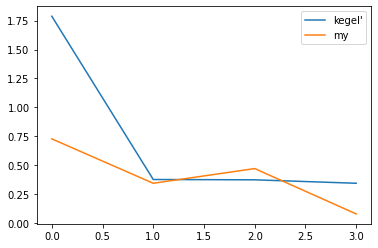

In [76]:
data = [(0.7279934116537219, 1.78762), (0.3442691858148595, 0.37692), (0.4712097699120553, 0.37409), (0.07946504219543002, 0.34433)]
df = pd.DataFrame({"kegel":[item[1] for item in data], "my":[item[0] for item in data]})
plt.plot(df)
plt.legend(["kegel'", "my"])


Фигово, но могло быть хуже